# COVID-19 diagnosis using CT images

## Construct Resnet-18 CNN and Train from scratch
Author: Annika Murray 

Date: 12/28/2023

In [1]:
import data_loader
from data_loader import get_dataloader
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
import random
from IPython import display
import seaborn as sns
import cv2


import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet18_Weights

from pytorch_grad_cam import (GradCAM, EigenCAM)
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [2]:
data_test, loader_train, loader_val, loader_test = get_dataloader()

In [3]:
len(data_test)

400

There are 400 images in our test set.

In [4]:
images=[]
labels=[]
for i in range(len(data_test)):
    image, label = data_test[i]
    images.append(image)
    labels.append(label)

In [5]:
labels.count(0)

200

There are 200 COVID CT scans and 200 Non-COVID scans.

### What does a COVID CT scan look like compared to a healthy CT scan?

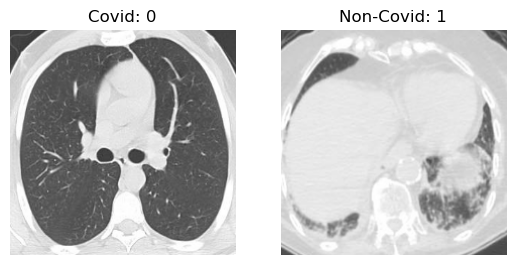

<Figure size 640x480 with 0 Axes>

In [6]:
# show some of the images
fig, ax = plt.subplots(1,2)
for n in range(15):
    x=images[n]
    y=images[n+200]
    ax[0].imshow(x.permute(1,2,0), cmap='gray')    
    ax[0].axis('off')
    ax[0].set_title("Covid: " + str(labels[n].item()))
    ax[1].imshow(y.permute(1,2,0), cmap='gray')    
    ax[1].axis('off')
    ax[1].set_title("Non-Covid: " + str(labels[n+200].item()))
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.5) 

Later, we will use these images to display insights into which regions of an input image are crucial for the model's decision in classifying a COVID CT scan versus a Non-COVID CT scan.

### Construct a CNN model by modifying Resnet-18

In [7]:
class ModResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(resnet18.children())[:-1])
        self.fc1 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
model=ModResNet18()

New ResNet18 Model strcuture for binary classification: Covid or Non-Covid

### 2) Train the CNN from scratch

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model device:", next(model.parameters()).device)

Model device: cpu


In [10]:
#Loss function optimizer
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [11]:
def cal_accuracy(confusion):
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()         
    return acc

In [12]:
#Variables to keep track of stuff
import time

epochs=5

train_loss_list=[]
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

#### Training Function

In [13]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    
    train_correct=0
    train_loss=0
    
    for X, Y in dataloader:
        X, Y = X.to(device), Y.to(device)
        
        #Predicting / Updating parameters
        optimizer.zero_grad()#clear grad of each parameters
        Z = model(X) # Forward pass; Get predicted values from model
        loss = nnF.cross_entropy(Z, Y) # Cross-entropy loss; compare predictions to actual
        loss.backward()#backward pass
        optimizer.step()#update parameters
        
        train_loss+=loss.item() #Getting train loss
        Yp = Z.data.max(dim=1)[1]  # Get the index of the max 
        train_correct += torch.sum(Yp==Y).item() #Correct predictions
        
    train_loss/=len(dataloader)
    train_correct/=len(dataloader.dataset) 

    print(f'Epoch: [{epoch}] Loss: {loss.item()} Training Acc: {train_correct}')
        
    return train_loss, train_correct

#### Testing Function

In [14]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    
    confusion=np.zeros((2,2))

    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            #Predicting / Updating parameters
            Z = model(X)# Forward pass; Get predicted values from model
            Yp = Z.argmax(dim=1)  # Get the index of the max
            
            #Confusion Matrix
            for i in range(0, 2):
                for j in range(0, 2):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    
    #Calculates the accuracy
    acc = cal_accuracy(confusion)
            
    return acc, confusion

In [15]:
print("Training attempt")
print("Started at 0.00")
start_time=time.time()
for epoch in range(epochs):
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    train_loss_list.append(loss_train)
    train_acc_list.append(acc_train)
    #-------- validation --------------------------------
    acc_val, other = test(model, device, loader_val)
    val_acc_list.append(acc_val)
    print(f'Validation Accuracy: {acc_val}')
    #-------- testing --------------------------------
    acc_test, confused = test(model, device, loader_test)
    test_acc_list.append(acc_test)
    print(f'Testing Accuracy: {acc_test}')
    
current_time=time.time()
total_time= current_time-start_time
print(f"Training time: {total_time/60} minutes")

Training attempt
Started at 0.00


Epoch: [0] Loss: 0.28020209074020386 Training Acc: 0.8911968348170128
Validation Accuracy: 0.8166666626930237
Testing Accuracy: 0.8725000023841858
Epoch: [1] Loss: 0.02943737991154194 Training Acc: 0.9693372898120672
Validation Accuracy: 0.9333333373069763
Testing Accuracy: 0.925000011920929
Epoch: [2] Loss: 0.0013689937768504024 Training Acc: 0.9915924826904056
Validation Accuracy: 0.9666666388511658
Testing Accuracy: 0.9674999713897705
Epoch: [3] Loss: 0.0003218641213607043 Training Acc: 0.9960435212660732
Validation Accuracy: 0.949999988079071
Testing Accuracy: 0.9624999761581421
Epoch: [4] Loss: 0.021768271923065186 Training Acc: 0.9985163204747775
Validation Accuracy: 0.9833333492279053
Testing Accuracy: 0.9825000166893005
Training time: 16.360843813419343 minutes


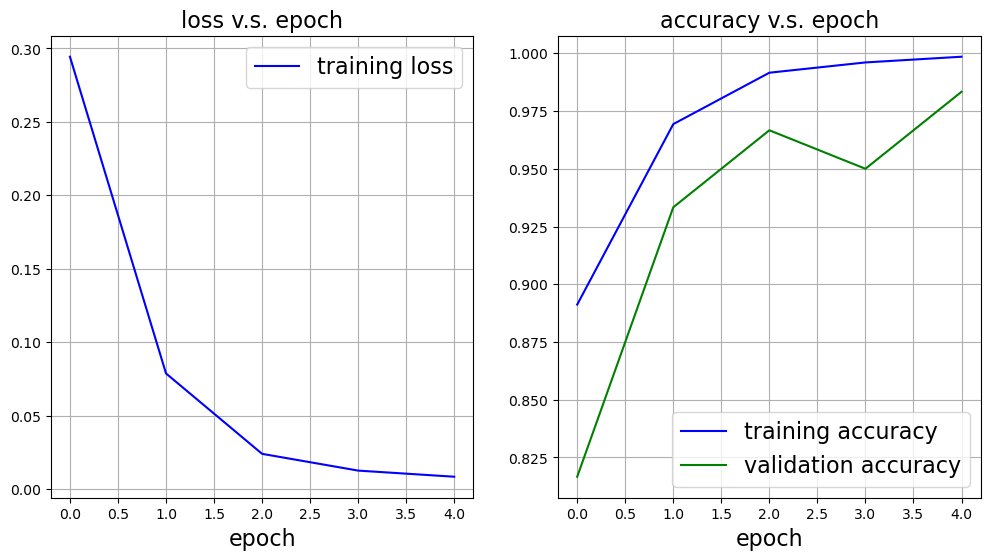

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(train_loss_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(train_acc_list, '-b', label='training accuracy')
ax[1].plot(val_acc_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

<Axes: >

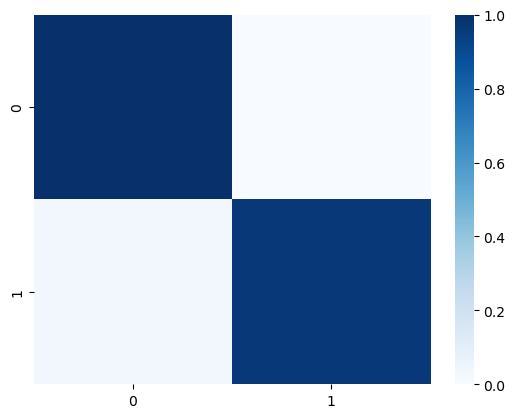

In [17]:
cm=confused/200 #confusion matrix
sns.heatmap(cm, annot=False,cmap="Blues")

### 4) Visualize the two models using two CAM methods

This helps researchers and practitioners understand where the model is focusing its attention.

In [18]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [19]:
all_layers = list(model.children())
last_layer = all_layers[-1]
print(last_layer)

target_layers=last_layer

Linear(in_features=512, out_features=2, bias=True)


### EigenCAM

images[0]: <class 'torch.Tensor'> shape:  torch.Size([3, 224, 224])
image_input: <class 'torch.Tensor'> shape:  torch.Size([1, 3, 224, 224])
grayscale_cam: <class 'numpy.ndarray'> shape:  (1, 224, 224)
grayscale_cam[0]: <class 'numpy.ndarray'> shape:  (224, 224)


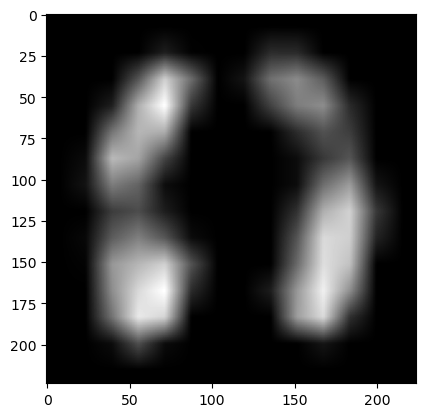

In [35]:
target_layers = [model.features[6][-1]]
print("images[0]:" , type(images[0]), "shape: " , images[0].shape)
image_input=images[0].reshape(1,3,224,224)
print("image_input:" , type(image_input), "shape: " , image_input.shape) # A batch that only has one image

## Constrcut the CAM
targets = [ClassifierOutputTarget(category=0)]
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
print("grayscale_cam:" , type(grayscale_cam), "shape: " , grayscale_cam.shape)
print("grayscale_cam[0]:" , type(grayscale_cam[0]), "shape: " , grayscale_cam[0].shape)
grey_spot=grayscale_cam[0]
plt.imshow(grey_spot, cmap='gray')


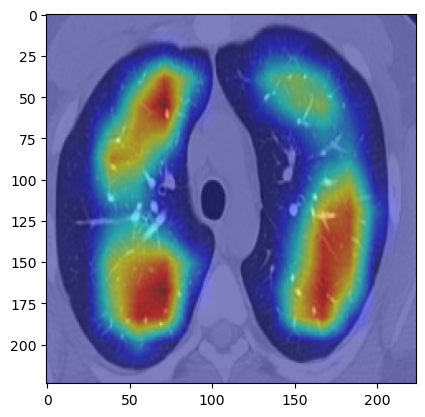

In [36]:
image=images[0].permute(1, 2, 0).numpy()
cam_image = show_cam_on_image(image, grey_spot, use_rgb=True)
plt.imshow(cam_image)

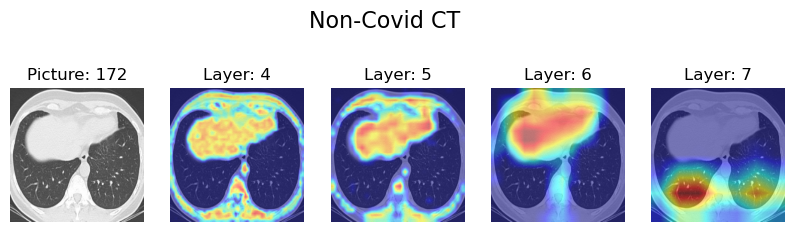

In [38]:
fig, ax = plt.subplots(1,5,figsize=(10, 3))
fig.suptitle('Non-Covid CT', fontsize=16)
n = random.randint(0, 199)
ax[0].imshow(images[n].permute(1,2,0), cmap='gray')    
ax[0].axis('off')
ax[0].set_title("Picture: " + str(n))
image_input=images[n].reshape(1,3,224,224)
targets = [ClassifierOutputTarget(category=0)]

for i in range(4,8):
    target_layers = [model.features[i][-1]]
    cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
    grayscale_cam = cam(input_tensor=image_input, targets=targets)
    image=images[n].permute(1, 2, 0).numpy()
    cam_image = show_cam_on_image(image, grayscale_cam[0], use_rgb=True)
    ax[i-3].imshow(cam_image)    
    ax[i-3].axis('off')
    ax[i-3].set_title("Layer: " + str(i))

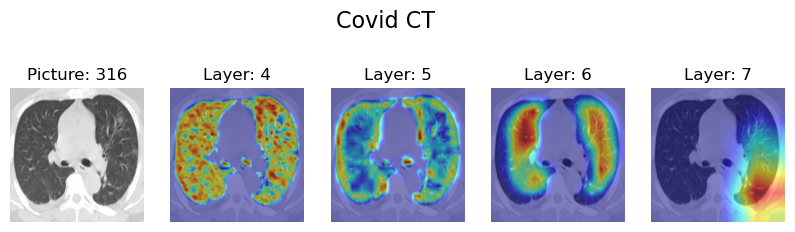

In [39]:
fig, ax = plt.subplots(1,5,figsize=(10, 3))
fig.suptitle('Covid CT', fontsize=16)

n = random.randint(200, 400)
ax[0].imshow(images[n].permute(1,2,0), cmap='gray')    
ax[0].axis('off')
ax[0].set_title("Picture: " + str(n))
image_input=images[n].reshape(1,3,224,224)
targets = [ClassifierOutputTarget(category=0)]

for i in range(4,8):
    target_layers = [model.features[i][-1]]
    cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
    grayscale_cam = cam(input_tensor=image_input, targets=targets)
    image=images[n].permute(1, 2, 0).numpy()
    cam_image = show_cam_on_image(image, grayscale_cam[0], use_rgb=True)
    ax[i-3].imshow(cam_image)    
    ax[i-3].axis('off')
    ax[i-3].set_title("Layer: " + str(i))